In [31]:
import numpy as np
import pandas as pd
import os
import calendar
import matplotlib.pyplot as plt

In [13]:
#!pip install openpyxl

## Import Data

In [2]:
#2018-2022 Data Sheets' Naming Format:  Ridership_yyyymm.xlsx
#2010-2017 Data Sheets' Naming Format: Ridership_Aprilyyyy.xlsx

In [11]:
pd.read_excel("Data/ridership_2010/Ridership_January2010.xlsx", header=1, index_col=0).head(5)

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55
RM,4.894737,107.526316,108.157895,89.684211,345.526316,79.894737,142.473684,134.210526,182.263158,35.631579,...,NaN,Eastbay,72413.894737,NaN,SF CBD,204901.842105,0.642676,NaN,NaN,NaN
EN,128.631579,10.842105,101.105263,83.157895,787.263158,123.157895,264.473684,419.789474,610.315789,88.789474,...,NaN,Westbay,90407.684211,NaN,non-CBD,107559.789474,0.337362,NaN,NaN,NaN
EP,105.789474,82.736842,4.947368,58.000000,586.684211,69.842105,120.789474,225.000000,269.368421,66.684211,...,NaN,Transbay,156004.421053,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NB,76.631579,65.631579,60.684211,7.842105,187.421053,53.000000,86.210526,206.315789,242.263158,57.842105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BK,381.842105,800.421053,580.526316,204.473684,14.105263,324.684211,428.000000,427.526316,503.368421,206.210526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
pd.read_excel("Data/ridership_2018/Ridership_201801.xlsx", header=1, index_col=0).head(5)

,RM,EN,EP,NB,BK,AS,MA,19,12,LM,...,NC,WP,SS,SB,SO,MB,WD,OA,WS,Exits
RM,12.761905,108.619048,81.904762,64.952381,365.619048,101.571429,138.047619,149.190476,180.095238,37.571429,...,2.190476,35.000000,12.190476,18.904762,58.714286,26.666667,7.619048,12.333333,7.476190,3934.952381
EN,131.952381,20.333333,91.285714,95.761905,825.857143,139.380952,261.619048,471.476190,562.285714,93.714286,...,5.571429,26.571429,34.095238,42.619048,113.619048,71.190476,13.285714,30.904762,26.476190,8247.380952
EP,86.428571,81.380952,12.857143,46.904762,659.190476,83.047619,133.761905,298.000000,336.333333,56.285714,...,3.666667,11.190476,10.285714,11.142857,60.333333,31.809524,7.476190,24.714286,11.000000,4702.190476
NB,72.380952,87.142857,51.047619,15.619048,199.619048,61.333333,91.190476,285.190476,249.333333,46.333333,...,3.285714,16.238095,7.857143,9.809524,91.380952,35.809524,8.000000,30.761905,16.571429,4396.142857
BK,405.619048,897.095238,667.809524,208.000000,35.619048,360.761905,361.904762,562.285714,528.428571,226.761905,...,49.142857,113.047619,34.428571,39.238095,179.904762,139.095238,48.523810,73.523810,78.380952,11122.666667


In [53]:
def monthly_weekday_counts(entry_station, exit_station, start_year, end_year):
    monthly_weekday_counts = []
    monthly_weekday_plot_label = []

    for year in np.arange(start_year, end_year, 1):
        dir_path = f'Data/ridership_{year}/'
        if year <= 2017:
            for month in np.arange(1, 13, 1):
                two_digits_format_month = '{:02d}'.format(month)
                file_name = f'Ridership_{calendar.month_name[month]}{year}.xlsx'
                file_path = os.path.join(dir_path, file_name)
                monthly_weekday_counts.append(pd.read_excel(file_path, header=1, index_col=0).loc[exit_station, entry_station])
                monthly_weekday_plot_label.append(f'{year}-{two_digits_format_month}')
        else:
            for month in np.arange(1, 13, 1):
                two_digits_format_month = '{:02d}'.format(month)
                file_name = f'Ridership_{year}{two_digits_format_month}.xlsx'
                file_path = os.path.join(dir_path, file_name)
                monthly_weekday_counts.append(pd.read_excel(file_path, header=1, index_col=0).loc[exit_station, entry_station])
                monthly_weekday_plot_label.append(f'{year}-{two_digits_format_month}')
                
    return monthly_weekday_counts, monthly_weekday_plot_label

### Berkeley - Embarcadero

In [54]:
Berkeley_Embarcadero, label = monthly_weekday_counts("BK", "EM", 2010, 2014)

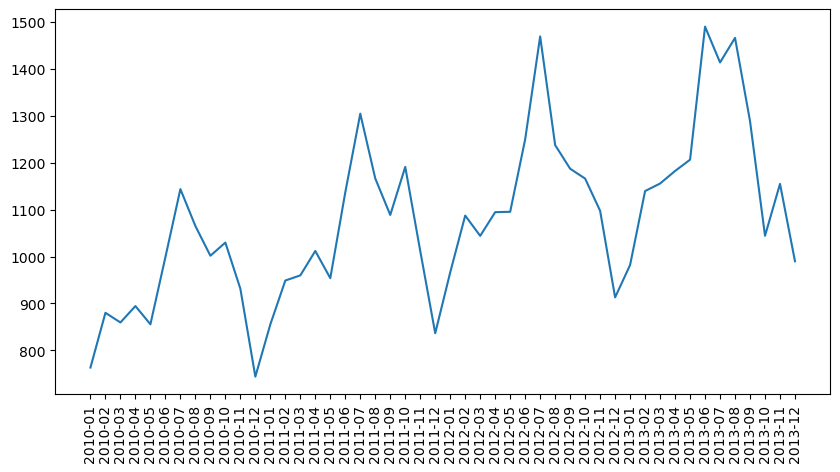

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(label, Berkeley_Embarcadero)
ax.set_xticks(label)
ax.set_xticklabels(label, rotation=90);